In [7]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')


-----
anndata     0.8.0
scanpy      1.9.3
-----
Experiments                 NA
PIL                         10.0.1
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
certifi                     2023.07.22
cffi                        1.15.1
charset_normalizer          3.1.0
colorama                    0.4.6
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
executing                   0.8.3
fa2                         NA
fontTools                   4.39.4
h5py                        3.9.0
hypergeom_ufunc             NA
idna                        3.4
igraph                      0.10.5
importlib_resources         NA
ipykernel                   6.19.2
jedi                        0.18.1
joblib                      1.1.1
kiwisolver    

In [8]:
import os
import sys
if 'Single_cell' in os.getcwd():
	os.chdir('../..')
	sys.path.insert(0,os.getcwd())
print(os.getcwd())
print(sys.path[0])

/export/home/enfita/Code/CST_official_github_repo
/mnt/BC38EA2938E9E27E/pycharm-2021.3.3/plugins/python/helpers-pro/jupyter_debug


In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lib.utils.utils import factor_number

from matplotlib.lines import Line2D

import re
from textwrap import wrap


import matplotlib.pyplot as plt
from lib.T_datacls import T_data
import numpy as np
from lib.T_datacls.utilities.visualisation import plot_graph
from Experiments.Single_cell.load_singlecell_data import load_paul15

### set parameters

In [10]:
distribution = 'paul'

tree_methods=['BCST_0.50','CST_0.50','mST']#,'BCST_0.70','CST_0.70','BCST_0.00']#,'BCST_1.00','CST_1.00']

#BCST parameters
maxiter_mSTreg=20
maxfreq_mSTreg=3
num_subsamples=1

save=False
folder='Figures/single_cell/'

### Load data and generate pertubed samples

preprocessing data
Applying zheng recipe
running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)
Computing PAGA embedding
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:25)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989278  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 

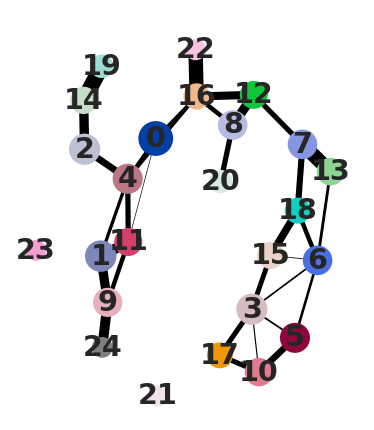

In [11]:
#load data
_,P,P_PAGA,labels=load_paul15()
labels_names=np.array(labels).astype(str)

# generate subsampled perturbed data
np.random.seed(12)
subsample_idxs_ls=[]
P_subsample_ls=[]
for i in range(num_subsamples):
    subsample_idxs=np.random.choice(np.arange(len(P)), replace=False, size=int(0.5 * len(P)))
    subsample_idxs_ls.append(subsample_idxs)
    P_subsample_ls.append(P[subsample_idxs])


n,ndim=P.shape


#Process labels and set colors
#remove distinction by number in labels
for i,l in enumerate(labels_names):
    labels_names[i] = re.compile("([0-9]+)([a-zA-Z]+)").match(l).groups()[1]

#labels to numeric values
labels=np.zeros_like(labels_names)
for i ,l in enumerate(np.unique(labels_names)):
    labels[labels_names == l] = i
labels=labels.astype(int)



'''colormap'''
vals = np.linspace(0,1,20)
np.random.seed(42)
cmap=plt.cm.tab20
vals=np.concatenate([vals[0::2],vals[1::2]])
cmap = plt.cm.colors.ListedColormap(cmap(vals))
#legend label names
legend_elements_label_names = [Line2D([0], [0], marker='o', color='w', label=str(l),
                              markerfacecolor=cmap(i), markersize=10) for i ,l in enumerate(np.unique(labels_names)) ]

node_colors_BCST= ['#1f77b4'] * len(P) + ['r'] * (len(P) - 2)
legend_elements_BP = [Line2D([0], [0], marker='o', color='w', label='Terminal',
                             markerfacecolor=node_colors_BCST[0], markersize=10),
                      Line2D([0], [0], marker='o', color='w', label='BP',
                          markerfacecolor=node_colors_BCST[-1], markersize=10), ]

In [12]:

param_method={}
for method in tree_methods:
    if 'CST' in method:
        param_method[method] ='itmSTReg=%i_maxfreqmSTreg=%i'%(maxiter_mSTreg,maxfreq_mSTreg)
    if 'mST' in method:
        param_method[method] = ''

### Plot data

In [13]:
P_PAGA.shape

(2730, 2)

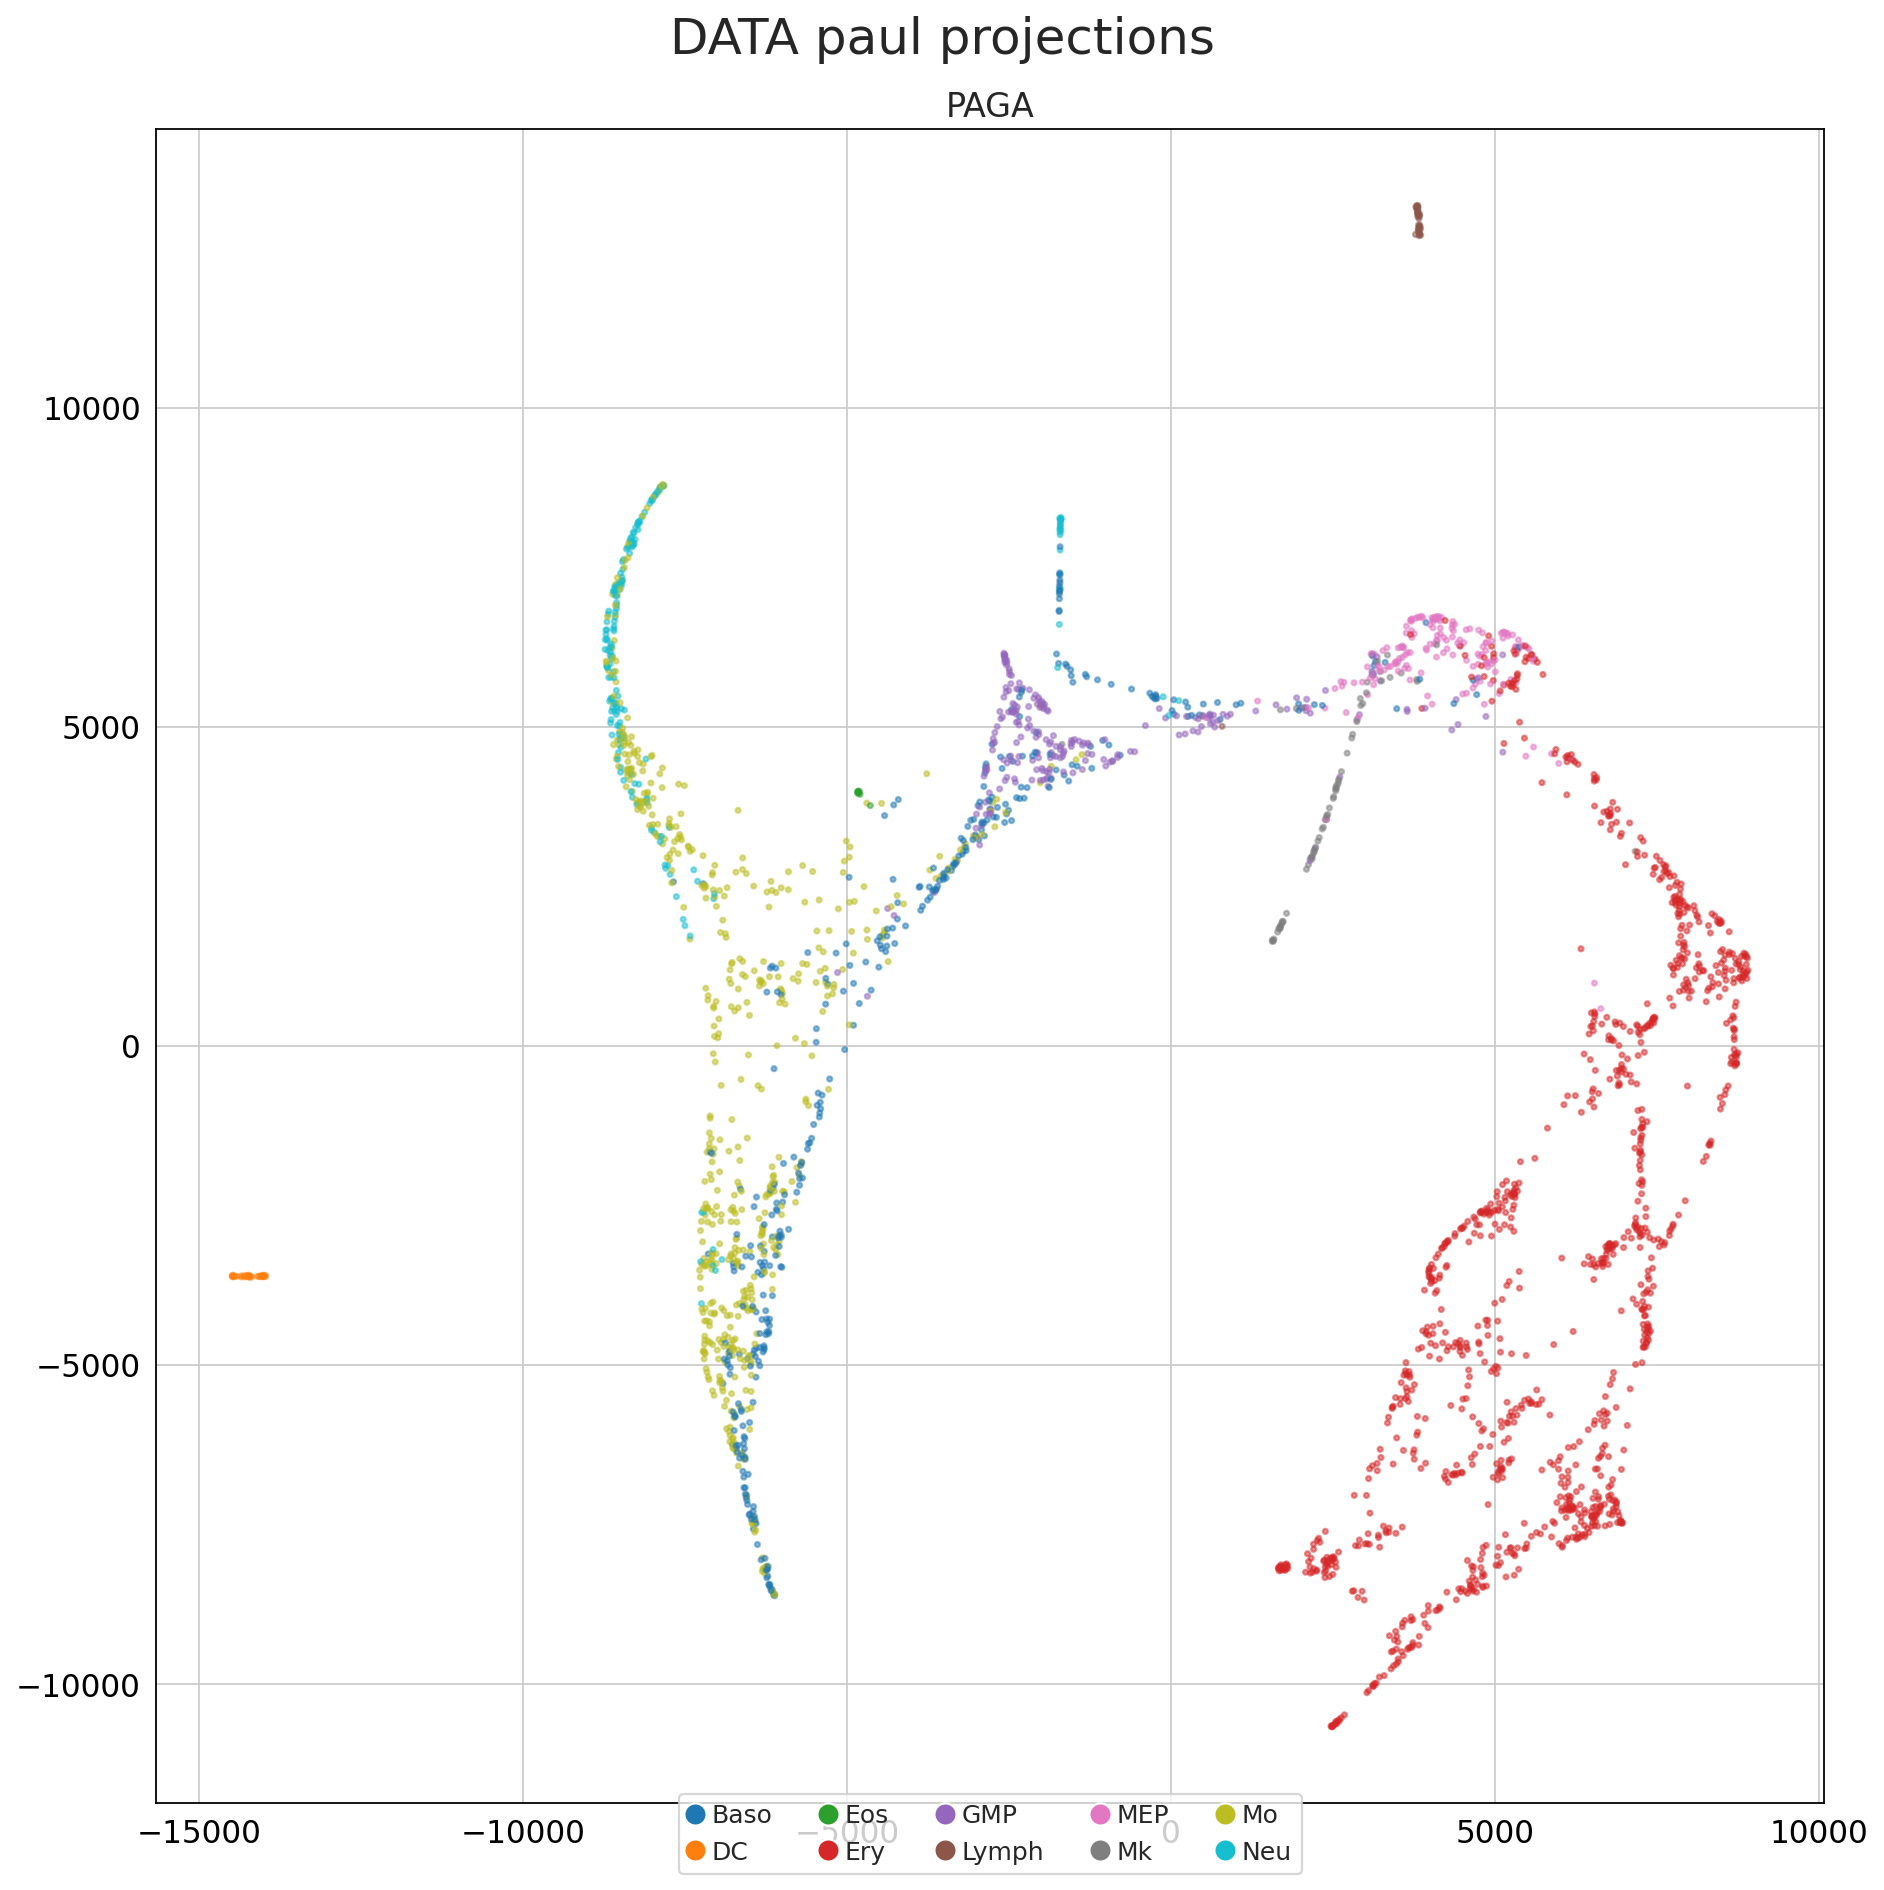

In [14]:
figsize=(12,12)

node_size=5
fontsize=15

plt.figure(figsize=figsize)
plt.scatter(P_PAGA[:,0],P_PAGA[:,1],c=cmap(labels),s=node_size,alpha=0.5)
plt.title('PAGA',fontsize=fontsize)
plt.suptitle('DATA %s projections'%distribution,fontsize=1.5*fontsize)
plt.legend(handles=legend_elements_label_names,fontsize=fontsize*.75,
           loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.tight_layout()

plt.show()

### Compute (B)CST

In [15]:
tdata_dict={}
tdata_dict['original']=T_data(P,P_PAGA)
# tdata_dict['noisy']=T_data(P_noise,P_vis_dict[projections_ls[0]])
for i in range(num_subsamples):
    tdata_dict['subsample%i'%i]=T_data(P_subsample_ls[i],P_PAGA[subsample_idxs_ls[i]])

# tdata_dict['rsubsample']=T_data(P_rsubsample,P_vis_dict[projections_ls[0]][subsample_idxs])

for tdata in tdata_dict.values():
    for method in tree_methods:
        if 'BCST' in method:
            alpha=float(method.split('_')[1])
            if alpha==0:
                return_topo_CST=False
            else:
                return_topo_CST=True
            tdata.compute_BCST(alpha=alpha,
                               maxiter_mSTreg=maxiter_mSTreg,
                               maxfreq_mSTreg=maxfreq_mSTreg,
                               merging_criterium='closest',
                               mST_fromknn=True,
                               return_topo_CST=return_topo_CST,
                               filter_BP_from_solution=True)
        elif method=='mST':
            tdata.minimum_spanning_tree()

INFO:Tdata_logger:Added  'X' to data

INFO:Tdata_logger:Added  'X_vis' to data

INFO:Tdata_logger:Added  'X' to data

INFO:Tdata_logger:Added  'X_vis' to data

INFO:Tdata_logger:Computing initial topology BCST mST
INFO:Tdata_logger:Computing mST 

INFO:Tdata_logger:Added  mST to trees

INFO:Tdata_logger:Computing BCST_0.50 and CST_0.50


best mSTreg obtained in iteration 20
best mSTreg CST obtained in iteration 19


INFO:Tdata_logger:Added  CST_0.50 to trees

INFO:Tdata_logger:Added  BCST_0.50 to trees

INFO:Tdata_logger:Function compute_BCST took 60.0009 seconds
INFO:Tdata_logger:Computing initial topology BCST mST
INFO:Tdata_logger:Computing mST 

INFO:Tdata_logger:Added  mST to trees

INFO:Tdata_logger:Computing BCST_0.50 and CST_0.50
INFO:Tdata_logger:Added  CST_0.50 to trees



best mSTreg obtained in iteration 21
best mSTreg CST obtained in iteration 2


INFO:Tdata_logger:Added  BCST_0.50 to trees

INFO:Tdata_logger:Function compute_BCST took 27.6209 seconds


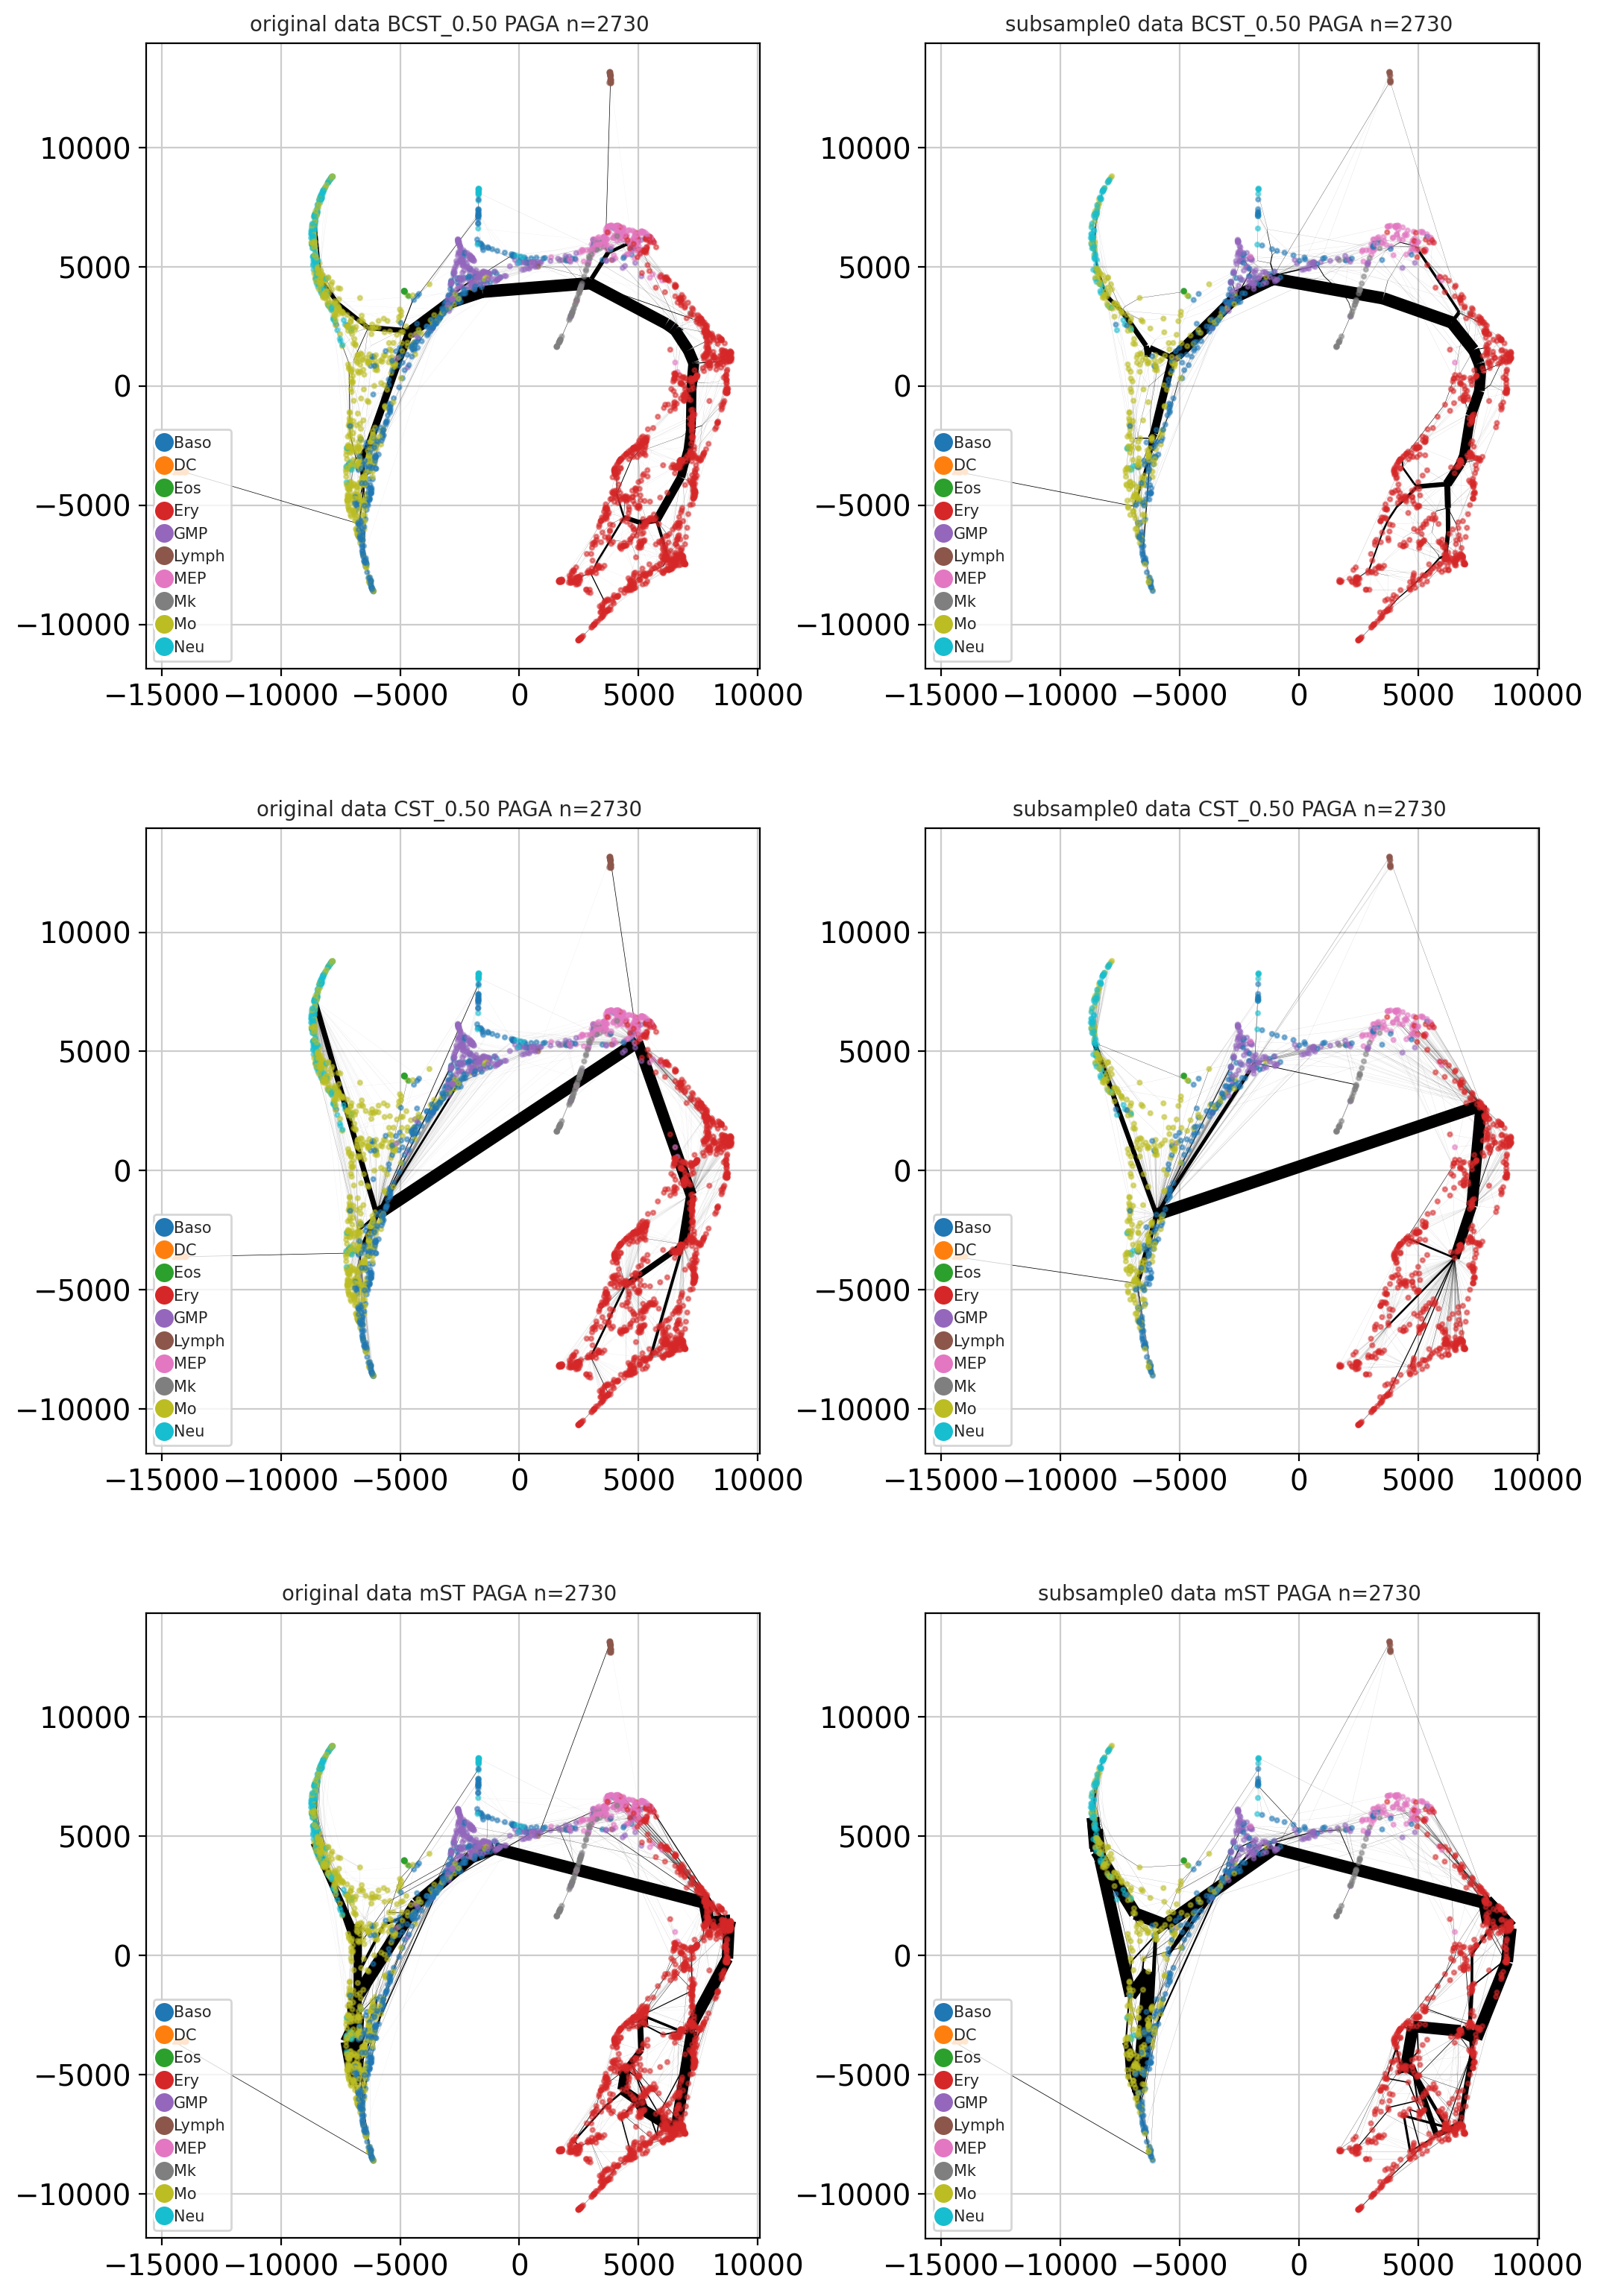

In [16]:
max_width=6
mST = tdata.trees['mST'].T

mST_widths = tdata.trees['mST'].widths*max_width
k1,k2=factor_number(1,reversed=False)
# figsize=(min(4,max(k1,k2))*np.array([6,k1/k2*6])).tolist()
figsize=None#(12,8)
fontsize=10
node_size=4
node_size_BP=0#node_size/30
if save:
    k1=k2=1
else:
    k1=len(tree_methods)
    k2=2

for data_type,tdata in tdata_dict.items():
    if 'subsample' in data_type and 'r' not in data_type:
        idxs=subsample_idxs_ls[int(data_type[-1])]
        is_subsample=1
    else:
        is_subsample=0
        idxs=np.arange(len(P))
    for counter_plot,method in enumerate(tree_methods):
        if save:
            counter_plot=0
        if 'BCST' in method:
            T=tdata.trees[method].T_bp_filtered
            T_widths = tdata.trees[method].widths_filtered * max_width
            visdata=tdata.trees[method].coords_vis_filtered
            node_cls=np.vstack([cmap(labels)[idxs],cmap(labels)])[:len(visdata)]
        else:
            T=tdata.trees[method].T
            T_widths = tdata.trees[method].widths * max_width
            visdata=tdata.X_vis
            node_cls=cmap(labels)[idxs]
        node_size_=node_size

        if np.isclose(min(T_widths),max(T_widths)):
            T_widths=np.ones_like(T_widths)*0.05


        subfolder = '%s/%s_%s/' % (distribution, method,param_method[method])
        file = 'Tree_%s_%s_%s_%s_n=%i_ndim=%i_%s' % (data_type,'PAGA', param_method[method], distribution, n, ndim,method)
        if save:
            title=''
        else:
            title = '%s data %s %s n=%i ' % (data_type,method,'PAGA', n)


        if 'BCST' in method:
            ax=plot_graph(T, visdata, widths=T_widths,
                       title=title, node_size=0,k1=k1,k2=k2,counter_plot=int((not save)*(counter_plot*2+is_subsample)),
                       node_colors=node_cls, figsize=figsize, fontsize=fontsize,
                       alpha_node=0.0,return_ax=True)
            plot_graph(T[:len(idxs)][:,:len(idxs)], visdata[:len(idxs)],
                       widths=0,
                       title=title, node_size=node_size_,k1=k1,k2=k2,counter_plot=int((not save)*(counter_plot*2+is_subsample)),
                       node_colors=node_cls[:len(idxs)], figsize=figsize,
                       fontsize=fontsize,
                       alpha_node=0.5, nodelist=np.arange(len(idxs)),new=False,ax=ax)
        else:
            plot_graph(T, visdata, widths=T_widths,
                       title=title, node_size=node_size_,k1=k1,k2=k2,counter_plot=int((not save)*(counter_plot*2+is_subsample)),
                       node_colors=node_cls, figsize=figsize, fontsize=fontsize,
                       alpha_node=0.5)
        if 'BCST' in method:
            # plt.legend(handles=legend_elements_BP, fontsize=fontsize * .75)
            plt.legend(handles=legend_elements_label_names, fontsize=fontsize * .75,
                       loc='lower left')
        else:
            plt.legend(handles=legend_elements_label_names, fontsize=fontsize * .75,
                       loc='lower left')


        plt.grid('off')
        if save:
            plt.axis('off')
            os.makedirs(folder + subfolder,True)
            plt.savefig(folder+subfolder+file+'.png',dpi=200,transparent=True)
            plt.close()
plt.tight_layout()
plt.show()